# SPML HW3 - Universal Adversarial Perturbation (30)

### Deadline: 1402/2/30

#### Name: Hamidreza Amirzadeh
#### Student No.: 401206999

**Initial Setups** 

In [ ]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np

# Please use CUDA

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))

#Let's try Drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
# !mkdir ./myCIFAR10



cuda
Tesla T4
Mounted at /content/drive
/content/drive/MyDrive


**Installing & Importing torchattacks for deepfool**

In [ ]:
"""
Deepfool attack is used in UAP algorithm
We suggest to use torchattacks library and its implemented DeepFool
"""

!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git

import torchattacks


**[1] Projection function**

In [ ]:
#In this function you wil implement projection due to the given norm (p) 
#For now, only p = 2 and p = Inf is needed to be supported by your function
#Project on the lp ball centered at 0 and of radius e

def proj_lp(v, e, p):

    if p == 2:
        v = v * min(1, e / np.linalg.norm(v.flatten(1)))
    elif p == np.inf:
        v = np.sign(v) * np.minimum(abs(v), e)
    return v

**[2] UAP generation**

In [ ]:
#In this function you will implement UAP algorithm for generating a universal perturbation based on the given dataset and model

def universal_pert(dataset, model, delta=0.1, max_iter_uni = np.inf, eps=10, p=np.inf, num_classes=10, df_overshoot=0.02, df_steps=10):
    '''
    :param dataset: Pytorch Dataset
    :param model: Model to be fooled by the adversarial examples
    :param delta: 1-delta represents the fooling_rate, and the objective (default = 90% fooling rate)
    :param max_iter_uni: Maximum number of iterations of the main algorithm
    :param eps: Controls the l_p magnitude of the perturbation (default = 10)
    :param p: Only p==2 or p==infinity are supported
    :param num_classes: Number of classes on the dataset
    :param df_overshoot: Parameter to the Deep_fool algorithm
    :param df_steps: Maximum iterations of the deep fool algorithm
    :return: perturbation found (and also fooling_rates for iterations and number of total_iterations)
    '''

    model.eval()

    # Initializing the perturbation to 0s
    v = torch.zeros([1,3,32,32]).to(device)


    #Initializing fooling rate and iteration count
    fooling_rate = 0.0
    iter = 0
    
    fooling_rates=[]
    total_iterations = []

    attack = torchattacks.DeepFool(model, steps=df_steps, overshoot=df_overshoot)

    """
    Begin of the main loop on Universal Adversarial Perturbations algorithm
    (Provide the conditions due to given delta and maximum number of iterations)
    """

    while fooling_rate < 1-delta and iter < max_iter_uni:
      print ('Starting pass number ', iter)

      # Go through the trainset and compute the perturbation increments sequentially
      for i, data in enumerate(dataset):
        image, label = data
        image = image.reshape([1,3,32,32]).to(device)
        
        #Complete the code due to the UAP algorithm
        label = torch.tensor(label, dtype = torch.long).reshape([1,1]).to(device)
        image_outs = model(image)
        _, image_pred = torch.max(image_outs.data, 1)

        preturbed = torch.clamp(image + v, 0, 1)
        preturbed_outs = model(preturbed)
        _, preturbed_pred = torch.max(preturbed_outs.data, 1)

        if image_pred == preturbed_pred:
                print('>> k = ', i, ', iter #', iter)
                adv_image = attack(torch.clamp(image + v, 0, 1), label)
                preturbation = adv_image - torch.clamp(image + v, 0, 1)
                v = v + preturbation
                v = v.detach().cpu()
                v = proj_lp(v, eps, p)
                v = v.to(device)
                """ 
                #Finding a new minimal perturbation with deepfool to fool the network on this image
                #your code goes here
                
                #Update v appropriately
                #your code goes here
                
                """
                
      iter = iter + 1

      with torch.no_grad():
        batch_size = 128
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

        total = 0
        fooled = 0

        for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          images_outs = model(images)
          _, images_pred = torch.max(images_outs.data, 1)

          preturbed = torch.clamp(images + v, 0, 1)
          preturbed_outs = model(preturbed)
          _, preturbed_pred = torch.max(preturbed_outs.data, 1)

          fooled = fooled + (preturbed_pred != labels).sum().item()
          total = total + images.shape[0]

        fooling_rate = fooled / total
        """Calculate fooling rate
        (Go through the dataset and check that v can fool the model or not. Calculate the ratio of fooled samples to total number of samples.)
        
        #your code goes here
        
        """

        torch.cuda.empty_cache()

        print("FOOLING RATE: ", fooling_rate)
        fooling_rates.append(fooling_rate)
        total_iterations.append(iter)

    return v,fooling_rates,total_iterations


**Loading CIFAR10**

In [ ]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

cifar_trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = True, download = True, transform = transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

cifar_testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = False, download = True, transform = transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size = batch_size, shuffle = False, num_workers = 2)


Files already downloaded and verified
Files already downloaded and verified


**[3]Loading model**

In [ ]:
from resnet import *

model = ResNet18()
model = model.to(device)
# model.train()

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


#Load model state dict using the given saved model (The model is trained with CIFAR10 trainset)
CIFAR10_model_PATH = "/content/drive/MyDrive/SPML_HW4_UAP_resnet18_cifar10_model_std"
state_dict = torch.load(CIFAR10_model_PATH)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in cifar_testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Standard Accuracy of ResNet18 model on the 10000 test images: {100 * correct / total} %')

Standard Accuracy of ResNet18 model on the 10000 test images: 76.78 %


**Generate universal perturbation for CIFAR10 using your function**

In [ ]:
#First, split the cifar testset into two distinct dataset (Note that number of samples from each class is balanced in these two dataset.)
#UAP_dataset: 50% of testset for using in your UAP algorithm
#evaluation_dataset: 50% of testset for final evaluation of UAP function (Calculating fooling rates of universal v over unseen cifar test samples)
#Then, use your UAP function for generating universal perturbation
from sklearn.model_selection import train_test_split

indexes = list(range(len(cifar_testset)))
UAP_indexes, test_indexes = train_test_split(indexes, test_size=0.5, random_state=42, stratify=cifar_testset.targets)
UAP_dataset = torch.utils.data.Subset(cifar_testset, UAP_indexes)
test_dataset = torch.utils.data.Subset(cifar_testset, test_indexes)

v, fooling_rates, total_iterations = universal_pert(UAP_dataset, model)

Streaming output truncated to the last 5000 lines.
>> k =  2718 , iter # 28
>> k =  2719 , iter # 28
>> k =  2721 , iter # 28
>> k =  2733 , iter # 28
>> k =  2736 , iter # 28
>> k =  2750 , iter # 28
>> k =  2751 , iter # 28
>> k =  2756 , iter # 28
>> k =  2768 , iter # 28
>> k =  2769 , iter # 28
>> k =  2799 , iter # 28
>> k =  2806 , iter # 28
>> k =  2812 , iter # 28
>> k =  2814 , iter # 28
>> k =  2815 , iter # 28
>> k =  2843 , iter # 28
>> k =  2854 , iter # 28
>> k =  2859 , iter # 28
>> k =  2873 , iter # 28
>> k =  2876 , iter # 28
>> k =  2884 , iter # 28
>> k =  2887 , iter # 28
>> k =  2896 , iter # 28
>> k =  2901 , iter # 28
>> k =  2913 , iter # 28
>> k =  2914 , iter # 28
>> k =  2917 , iter # 28
>> k =  2918 , iter # 28
>> k =  2923 , iter # 28
>> k =  2932 , iter # 28
>> k =  2939 , iter # 28
>> k =  2941 , iter # 28
>> k =  2942 , iter # 28
>> k =  2947 , iter # 28
>> k =  2948 , iter # 28
>> k =  2949 , iter # 28
>> k =  2950 , iter # 28
>> k =  2964 , iter # 28

**[4] Plot fooling rates over iterations in UAP**



Text(0, 0.5, 'Fooling Rate')

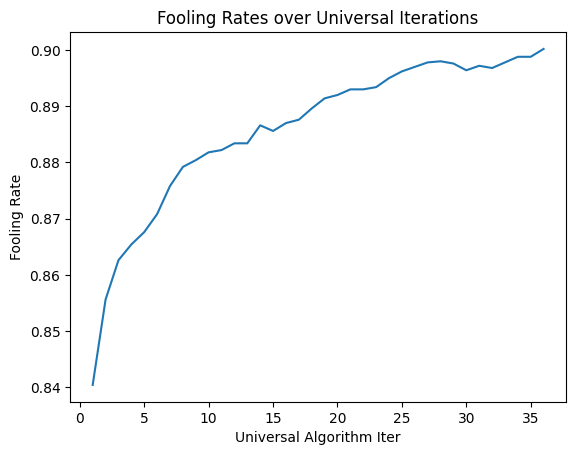

In [ ]:
import matplotlib.pyplot as plt
"""
your code goes here
"""
plt.plot(total_iterations, fooling_rates)
plt.title("Fooling Rates over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Fooling Rate")

**[6] Evaluate fooling rate of universal v on testset**

In [ ]:
#In this section, you will calculate the ratio of fooled samples to total number of samples over unseen test samples

total = 0
fooled = 0

#check the robustness of model on perturbed test samples with your universal perturbation (output of your algorithm on previous sections)
"""
    your code goes here
"""
with torch.no_grad():
    batch_size = 128
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

    total = 0
    fooled = 0

    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      images_outs = model(images)
      _, images_pred = torch.max(images_outs.data, 1)

      preturbed = torch.clamp(images + v, 0, 1)
      preturbed_outs = model(preturbed)
      _, preturbed_pred = torch.max(preturbed_outs.data, 1)

      fooled = fooled + (preturbed_pred != labels).sum().item()
      total = total + images.shape[0]

    evaluation_fooling_rate = fooled / total

print(evaluation_fooling_rate)

0.831


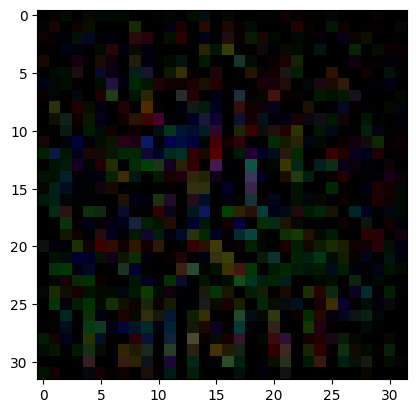

In [ ]:
plt.imshow((v).squeeze().detach().cpu().permute(1,2,0))